In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils.dataInfo import getTrainData, getTestData, plot_pixel_array, rle2mask
from utils.pneumonia_dataset import PneumoniaDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom
from scipy.sparse import csc_matrix, save_npz, load_npz
import scipy
from networks.network import Thicc_Net
from utils.pneumonia_dataset import PneumoniaDataset
from utils.trainer import train_loop

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
trainPath = 'siim/dicom-images-train/'
testPath = 'siim/dicom-images-test/'
maskPath = 'siim/mask/'

In [3]:
rles_df = pd.read_csv('siim/train-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']

In [4]:
train_df = getTrainData(trainPath, rles_df)
test_df = getTestData(testPath)

In [5]:
train_df.iloc[100]

encoded_pixels_count                                                    2
encoded_pixels_list     [ 736990 1 1022 2 1022 5 1019 5 1019 6 1018 7 ...
file_path               siim/dicom-images-train/1.2.276.0.7230010.3.1....
has_pneumothorax                                                     True
id                      1.2.276.0.7230010.3.1.4.8323329.10093.15178752...
patient_age                                                            44
patient_id                           7ba392eb-076e-45a1-9120-64bc2f3212ea
patient_name                         7ba392eb-076e-45a1-9120-64bc2f3212ea
patient_sex                                                             F
pixel_spacing                  [0.14300000000000002, 0.14300000000000002]
Name: 100, dtype: object

In [6]:
df_pos = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==True])
df_neg = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==False])

In [7]:
len(df_pos), len(df_neg), int(np.floor(len(df_pos)*.8))

(2379, 8296, 1903)

In [8]:
#20ish % for val 
train_df= pd.concat([df_pos.iloc[:1904], df_neg[:6637]])
val_df = pd.concat([df_pos.iloc[1904:], df_neg[6637:]])

In [9]:
len(train_df), len(val_df)

(8541, 2134)

In [10]:
def sampleImage(df,imgNum):
    dat = pydicom.dcmread(df.iloc[imgNum]['file_path']).pixel_array
    plt.figure()
    plt.subplots(figsize=(10,10))
    plt.imshow(dat, cmap='gray')
    
    if df.iloc[imgNum]['has_pneumothorax']:
        mk = load_npz('siim/mask/'+df.iloc[imgNum]['id']+'.npz').todense().astype('uint8')
        mk[mk>0]=1    
        plt.imshow(mk, alpha=.4)
    plt.show()

<Figure size 432x288 with 0 Axes>

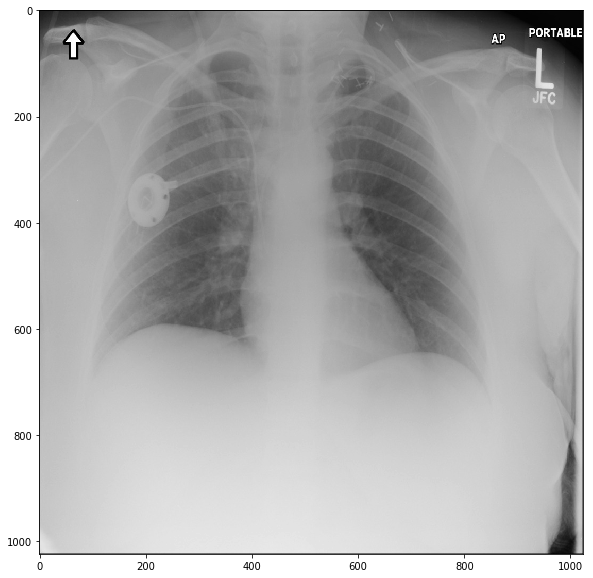

In [11]:
sampleImage(train_df,2220)

In [12]:
def image(img, lb=None, sz=10,color='gray'):
    plt.figure()
    plt.subplots(figsize=(sz,sz))
    plt.imshow(img, cmap=color)
    if lb is not None:
        plt.imshow(lb, alpha=.4, cmap='prism')
    plt.show()

In [13]:
def image_grid(img,mask=None, grid_x=4, grid_y=5,fig_size=(18,18)):
   
    fig, axes = plt.subplots(grid_x,grid_y, figsize=fig_size,
                         subplot_kw={'xticks': [], 'yticks': []})
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for ax, i in zip(axes.flat, range(len(img))):
        
        if mask is not None:
            ax.imshow(img[i], cmap='gray')
            ax.imshow(mask[i], alpha=.4)
        else:
            ax.imshow(img[i], cmap='gray')
    plt.show()
    

In [15]:
pneumoni_dataset_train = PneumoniaDataset(train_df,
                                      dims=256,                                      
                                      train=True, 
                                      val=False,
                                      transform=False)

pneumoni_dataset_val = PneumoniaDataset(val_df,
                                      dims=256,                                      
                                      train=True, 
                                      val=True,
                                      transform=False)

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=pneumoni_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(dataset=pneumoni_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False,
                                           drop_last=True)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
len(train_df)

8541

In [18]:
int(np.floor(len(train_df)*.8))

6832

In [19]:
img, lb = next(iter(train_loader))

In [22]:
img[0][0].max(), img[0][0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [23]:
lb[0][0].max(), lb[0][0].min()

(tensor(1, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

<Figure size 432x288 with 0 Axes>

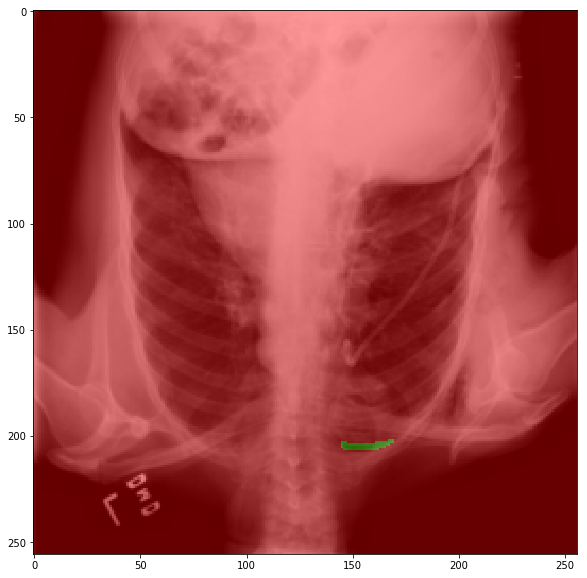

In [19]:
image(img[14][0], lb[14][0])

In [24]:
# model = Unet_res()
# model = Thicc_Net([2,2,2,2]) 
# model.cuda()


model = Thicc_Net([4,4,4,4]) 
if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

Thicc_Net(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU()
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [25]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[500], gamma=0.1)

In [26]:
save_bst = 'exp/exp2/best.pth'
save_last = 'exp/exp2/last.pth'

hist = train_loop(train_loader,val_loader,model,optimizer,scheduler,criterion,
                 save_bst,save_last,2000)

EPOCH:  1


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Training loss:....... 0.08346761586965808
Validation loss:..... 0.022763874759911595
NEW BEST Loss: 0.022763874759911595 ........old best:99999

Epoch time: 0:06:28.519255
 
EPOCH:  2
Training loss:....... 0.045153911880743434
Validation loss:..... 0.016957579562230443
NEW BEST Loss: 0.016957579562230443 ........old best:0.022763874759911595

Epoch time: 0:06:28.930435
 
EPOCH:  3
Training loss:....... 0.042354669407932664
Validation loss:..... 0.01766543938337188
Epoch time: 0:06:29.543812
 
EPOCH:  4
Training loss:....... 0.040228707065865205
Validation loss:..... 0.02388944115517731
Epoch time: 0:06:28.596398
 
EPOCH:  5
Training loss:....... 0.0392257227242608
Validation loss:..... 0.017661803373996924
Epoch time: 0:06:28.029280
 
EPOCH:  6
Training loss:....... 0.03722636636493354
Validation loss:..... 0.015330959099197858
NEW BEST Loss: 0.015330959099197858 ........old best:0.016957579562230443

Epoch time: 0:06:28.875719
 
EPOCH:  7
Training loss:....... 0.03524885726411168
Vali

Training loss:....... 0.016417737106668568
Validation loss:..... 0.0141392332979625
Epoch time: 0:06:29.118235
 
EPOCH:  62
Training loss:....... 0.016841174858162708
Validation loss:..... 0.012954807568068398
Epoch time: 0:06:29.976924
 
EPOCH:  63
Training loss:....... 0.016631235111693503
Validation loss:..... 0.012931004135092175
Epoch time: 0:06:30.716655
 
EPOCH:  64
Training loss:....... 0.016296078509513087
Validation loss:..... 0.013357143235546922
Epoch time: 0:06:30.766855
 
EPOCH:  65
Training loss:....... 0.01607195372076436
Validation loss:..... 0.013546070666927704
Epoch time: 0:06:28.785639
 
EPOCH:  66
Training loss:....... 0.01626431594006927
Validation loss:..... 0.01301015786086104
Epoch time: 0:06:28.858369
 
EPOCH:  67
Training loss:....... 0.015869807531466572
Validation loss:..... 0.013564569223497091
Epoch time: 0:06:28.498491
 
EPOCH:  68
Training loss:....... 0.016185459074534572
Validation loss:..... 0.012674866614012481
Epoch time: 0:06:29.047025
 
EPOCH:  

KeyboardInterrupt: 

In [ ]:
test_df.iloc[0]

In [ ]:
len(test_df), test_df.iloc[0]['file_path']

In [ ]:
test_l = len(test_df)

dims = 1024

X_test = np.zeros((test_l,dims, dims), dtype=np.float32)


In [ ]:
for i in range(test_l):
    
    X_test[i] = pydicom.dcmread(test_df.iloc[i]['file_path']).pixel_array

In [ ]:
X_test.shape

In [ ]:
X_test = X_test.reshape((-1,1,256,256))

In [ ]:
X_test.shape

In [ ]:
# image_grid(X_test[220:240])
plt.imshow(X_test[0][0], cmap='gray')